# COPDGene1 Fagerstrom Test For Nicotine Dependence (FTND) GWAS
__Author:__ Jesse Marks

See [GitHub Issue #78](See [GitHub Issue #78](https://github.com/RTIInternational/bioinformatics/issues/78))

This document logs the steps taken to process:

* `Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute` data and perform the FTND GWAS. The [COPDGene](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000179.v1.p1) cohort is racially diverse and sufficiently large and appropriately designed for genome-wide association analysis of COPD. 

* There are 10k subjects including control smokers, definitie COPD cases (GOLD Stage 2 to 4) and subjects not included in either group (GOLD 1 or GOLD-Unclassified). 

* The focus of this study is genome-wide association analysis to identify the genetic risk factors that determine susceptibility for COPD and COPD-related phenotypes.

* Our phenotype of interest is FTND

FTND is a standard instrument for assessing the physical addiction to nicotine. For more information, see [this website](https://cde.drugabuse.gov/instrument/d7c0b0f5-b865-e4de-e040-bb89ad43202b).

The imputed genotype are stored on Amazon Web Services S3 at:

`s3://rti-nd/COPDGene`

* We use the variable `FTNDboth_cat` variable that lumps together the former smokers that have lifetime FTND (N=736) with the current smokers that have current FTND (N=78). This will optimize sample size, especially since the severe category is slim.

* **Note**: I will first perform the GWAS with only the autosomes 

* John Guo would like me to try this with the nextFlow pipeline

## Notes about study
**Note**: these notes are not cohesive but serve as a personal reference for information I gathered on the study

* we have 1000 Genomes phase 3 imputation already available on the full COPDGene dataset

* we will run COPDGene1 and COPDGene2 separately because FTND was collected several years apart and there were some key differences in the way that the questions were asked in the different waves. We will keep the two waves separate to circumvent any potential discrepancies which could arrise because of the phenotypes being less than harmonious and then we will combine them in a meta-analysis later. 


* I will run the GWAS analysis with the following variables:

**COPDGene2** (all data from phase 2 LFU dataset, except for gender and finalGOLD which was collected only in phase 1)
The criteria for COPDGene2 are:

```1) WstFTND_cat_p2 (mostly former smokers with some current smokers picked up)
2) age_p1 (age at current visit)
3) gender (1=male, 2=female)
4) Goldneg1 (between case and control - exhibits signs of both. Failed one diagnostic test while passing another.)
5) Gold1or2 (cases)
6) Gold3or4 (severe cases)
7) EVs to be selected```

**Also, I need to split the data up by race** (1=white, 2=black) 


**Note** We cannot assume that the increments in the GOLD classification are equal which is why we need to embed dummy variables rather than a single categorical variable in our regression models.

* GOLD stands for the Global Initiative for Chronic Obstructive Lung Disease. Essentially, GOLD it is a metric for quantifying the severity of COPD a patient has.

* FTND outcome and covariates are now ready at the path:
    
    `\\rcdcollaboration01.rti.ns\GxG\Analysis\COPDGene\phenotypes\Phase2\COPD Both waves with Cat FTND_v2.xls`
    

* For COPDGene1, we are increasing the sample size by several hundred. This is because, the previous analysis of COPDGene1 included only the subjects with determinant COPD GOLD status (finalGold=0 for controls, 1/2 for cases, and 3/4 for severe cases.) Now we know that subjects with an indeterminant status (i.e. finalGold=-1) were subjects that were classified to be between case and control. With this newfound knowledge, we can go ahead and include these subjects and rerun COPDGene1 with these subjects plus the subjects that were in the previous analysis. The model will be:

`CurFTND_cat_p1 = SNP + age_p1 + gender + Goldneg1 +Gold1or2 + Gold3or4 + EVs to be selected`
    * Also note that in this phase1, the subjects were all current smokers. (max N=5289)

* For phase2, COPDGene2, we need to exclude all of the subjects which were included in COPDGene1. This will leave *mostly* former smokers with lifetime FTND reported (max N=2934). There will be some current smokers picked up in phase2 and we will include them here.

`WstFTND_cat_p2 = SNP + age_p1 + gender + Goldneg1 +Gold1or2 + Gold3or4 + EVs to be selected`


* So, 2,934 is the maximum number of subjects that will be included in COPDGene2. We will have to filter this down based on if the subjects have `sex, age, GOLD status,` and `genotype data.` Also, there are reportedly 4 subjects for COPDGene2 (have entries for the WstFTND_cat_p2 variable) that are missing finalGold status. Of those 4, 3 marked 0 for `Goldneg1`, `Gold1or2`, or `Gold3or4` and the other 1 has NA for those three variables. We will treat these 4 subjects as missing and exclude them from the analysis.

### CstFTND_cat_p2 variable description
| cat | Freq |
|-----|------|
| 0   | 1,506 |   
| 1   | 2,353 |   
| 2   | 1,430 |   

* Where FTND conversion is 0=0-3, 1=4-6, and 2=7+

# Prepare files for ProbABEL
## Phenotype Data COPDGene1
**Age p1 filtered table**
___


| Filtering Criterion                   | Subjects Removed  | Total |
|---------------------------------------|-------------------|-------|
| Initial Data                          | 0                 | 10,300|
| Initial subjects (CurFTND)            | 5,011             | 5,289 |
| Missing finalgold status              | 47                | 5,242 |
| Missing sex                           | 0                 | 5,242 |
| Missing age (p1)                      | 0                 | 5,242 |
| Missing Genotype                      | 159               | 5,083 |

* Number of EAs: 2,549 
* Number of AAs: 2,534 


___
**Age p2 filtered table**


| Filtering Criterion                   | Subjects Removed  | Total |
|---------------------------------------|-------------------|-------|
| Initial Data                          | 0                 | 10,300|
| Initial subjects (CurFTND)            | 5,011             | 5,289 |
| Missing finalgold status              | 47                | 5,242 |
| Missing sex                           | 0                 | 5,242 |
| Missing age (p2)                      | 2,353             | 2,889 |
| Missing Genotype                      | 80                | 2,809 |

* Number of EAs: 1,466
* Number of AAs: 1,343

### Apply Filters

In [11]:
pheno.data <- read.table("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/Copy of COPD Both waves with Cat FTND_v2.csv",
                        sep=",", header=T)

table(pheno.data$CurFTND_cat_p1)
print("Below is the table head of the entire phenotype file.")
head(pheno.data)


   0    1    2 
1506 2353 1430 

[1] "Below is the table head of the entire phenotype file."


sid    gender race ethnic fagerstrom_index finalgold age_p1 age_p2 have_lfu
1 15814W 2      1    2      NA               -2        NA     NA             
2 16032X 1      1    2      NA               -2        NA     NA             
3 16126G 2      1    2      NA               -2        NA     NA             
4 16281S 2      1    2      NA               -2        NA     NA             
5 16303C 1      1    2      NA               -2        NA     NA             
6 16311B 2      1    2      NA               -2        NA     NA             
  fagerstrom_index_lfu CurFTND_cat_p1 WstFTND_cat_p2 Gold_Cat Goldneg1 Gold1or2
1 NA                   NA             NA             NA       NA       NA      
2 NA                   NA             NA             NA       NA       NA      
3 NA                   NA             NA             NA       NA       NA      
4 NA                   NA             NA             NA       NA       NA      
5 NA                   NA             NA             NA       NA       NA      
6 NA                   NA             NA             NA       NA       NA      
  Gold3or4
1 NA      
2 NA      
3 NA      
4 NA      
5 NA      
6 NA

#### Initial numbers

In [8]:
# COPDGene1
# Calculate number of subjects with CurFTND data
cur.ftnd.vec <-  which(pheno.data$CurFTND_cat_p1 >= 0)

cur.ftnd.filtered <- pheno.data[cur.ftnd.vec,]
print("Max number of subjects for COPDGene1 (both ancestries)")
length(cur.ftnd.filtered[,1])

print("Below is the table head of the COPDGene1 data before any filters (save FTND) have been applied.")
head(cur.ftnd.filtered)

[1] "Max number of subjects for COPDGene1 (both ancestries)"


[1] 5289

[1] "Below is the table head of the COPDGene1 data before any filters (save FTND) have been applied."


sid    gender race ethnic fagerstrom_index finalgold age_p1 age_p2 have_lfu
101 10008W 1      1    2      1                -1        55.1     NA           
104 10248Q 1      1    2      9                -1        66.9     NA           
109 10521I 2      1    2      5                -1        53.3     NA           
113 10604M 2      1    2      5                -1        64.9   70.5   LFU     
116 10705S 2      1    2      3                -1        70.6   76.4   LFU     
119 10918J 2      1    2      4                -1        54.0     NA           
    fagerstrom_index_lfu CurFTND_cat_p1 WstFTND_cat_p2 Gold_Cat Goldneg1
101 NA                   0              NA             1        1       
104 NA                   2              NA             1        1       
109 NA                   1              NA             1        1       
113  4                   1               1             1        1       
116  4                   0               1             1        1       
119 NA                   1              NA             1        1       
    Gold1or2 Gold3or4
101 0        0       
104 0        0       
109 0        0       
113 0        0       
116 0        0       
119 0        0

#### Missing finalgold filter
Remove subjects missing `finalgold` variable

In [12]:
# some subjects with reported GOLD status are missing in the finalgold variable
gold.data <- cur.ftnd.filtered$finalgold[]
print("These are the sequential indices in the cur.ftnd.filtered at which they occur.")
which(is.na(gold.data))
print("Number of subjects missing finalgold.")
length(which(is.na(gold.data)))

print("Here are the data of those subjects with missing finalgold.")
cur.ftnd.filtered[which(is.na(gold.data)),]

# exclude those subjects with missing finalgold
cur.ftnd.fg.filtered <- cur.ftnd.filtered[-which(is.na(gold.data)),]

print("Number of subjects remaining after filtering by missing finalgold data.")
length(cur.ftnd.fg.filtered[,1])

[1] "These are the sequential indices in the cur.ftnd.filtered at which they occur."


[1] 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631 2632 5256 5257
[16] 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272
[31] 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287
[46] 5288 5289

[1] "Number of subjects missing finalgold."


[1] 47

[1] "Here are the data of those subjects with missing finalgold."


sid    gender race ethnic fagerstrom_index finalgold age_p1 age_p2
6866  10279B 1      1    2      2                NA        68.2     NA  
6867  10818F 1      1    2      3                NA        63.2     NA  
6869  11125F 1      1    2      4                NA        55.9   61.0  
6870  11182R 1      1    2      7                NA        64.5   72.7  
6871  11832E 2      1    2      7                NA        60.4     NA  
6876  15765J 1      1    2      5                NA        53.7   59.9  
6877  17778C 2      1    2      5                NA        62.8   68.0  
6878  18595Z 2      1    2      4                NA        47.5     NA  
6879  18916T 2      1    2      8                NA        64.3     NA  
6880  19004H 1      1    2      6                NA        66.0   71.0  
6881  21613Y 1      1    2      3                NA        47.1   52.7  
6882  22271B 1      1    2      6                NA        53.8     NA  
6883  24152D 1      1    2      5                NA        56.0     NA  
10258 10321A 1      2    2      7                NA        57.5   63.4  
10259 11122Z 1      2    2      6                NA        49.1     NA  
10260 11180N 1      2    2      6                NA        48.6   54.0  
10261 11272S 1      2    2      6                NA        55.0     NA  
10262 11576M 2      2    2      3                NA        47.4   52.7  
10263 12228U 2      2    2      7                NA        54.5     NA  
10264 12670J 2      2    2      5                NA        52.0     NA  
10265 12838V 1      2    2      5                NA        52.9     NA  
10266 13274G 2      2    2      8                NA        61.1   67.2  
10267 14465S 1      2    2      4                NA        57.3   65.0  
10268 14509M 2      2    2      6                NA        50.2   55.3  
10270 14782E 1      2    2      3                NA        53.8     NA  
10271 14959R 1      2    2      5                NA        56.3     NA  
10274 15416K 1      2    2      5                NA        47.6   53.5  
10275 15498M 1      2    2      8                NA        54.1     NA  
10276 15791K 1      2    2      5                NA        53.4     NA  
10277 15828H 1      2    2      7                NA        54.1     NA  
10278 16376D 1      2    2      7                NA        48.5     NA  
10279 16690J 1      2    2      9                NA        59.0     NA  
10280 16970P 1      2    2      0                NA        46.5   54.2  
10281 17394K 1      2    2      7                NA        59.7     NA  
10282 17447F 1      2    2      4                NA        46.9   52.9  
10284 17650C 2      2    2      9                NA        48.9   53.5  
10285 18113H 1      2    2      2                NA        53.8     NA  
10287 18546M 2      2    2      8                NA        62.5     NA  
10288 18930N 1      2    2      7                NA        61.3   66.4  
10290 19964J 2      2    2      3                NA        52.4     NA  
10291 20010P 2      2    2      2                NA        59.9   66.1  
10292 20433R 2      2    2      6                NA        47.8   52.6  
10293 20572F 2      2    2      7                NA        50.5     NA  
10295 24586K 1      2    2      5                NA        53.5   60.2  
10296 25522P 1      2    2      9                NA        45.2     NA  
10299 25576M 1      2    2      2                NA        50.6   55.3  
10300 25929T 2      2    2      8                NA        45.3     NA  
      have_lfu fagerstrom_index_lfu CurFTND_cat_p1 WstFTND_cat_p2 Gold_Cat
6866           NA                   0              NA             NA      
6867           NA                   0              NA             NA      
6869  LFU       5                   1               1             NA      
6870  LFU       6                   2               1             NA      
6871           NA                   2              NA             NA      
6876  LFU       1                   1               

[1] "Number of subjects remaining after filtering by missing finalgold data."


[1] 5242

#### Missing Sex filter
Remove any subjects missing sex data.

In [13]:
# filtered out any subjects missing sex data
cur.ftnd.fg.sex.filtered <- cur.ftnd.fg.filtered[complete.cases(cur.ftnd.fg.filtered[, "gender"]),]

print("Number of COPDGene1 subjects after FTND, finalgold, and sex filtering.")
length(cur.ftnd.fg.sex.filtered[,1])

[1] "Number of COPDGene2 subjects after FTND, finalgold, and sex filtering."


[1] 5242

**Note:** no subjects missing sex data. 

#### Missing Age filter
Remove any subjects missing age data. 

#### age_p1
Filter by variable `age_p1` then write to file.

In [18]:
cur.ftnd.fg.sex.age1.filtered <- cur.ftnd.fg.sex.filtered[complete.cases(cur.ftnd.fg.sex.filtered[,"age_p1"]),]

print("Number of COPDGene1 subjects after FTND, finalgold, sex, and age (p1) filtering.")
length(cur.ftnd.fg.sex.age1.filtered[,1])

variables.of.interest1 <- c("sid", "gender", "race", "age_p1", "CurFTND_cat_p1", "Goldneg1", "Gold1or2", "Gold3or4")
pheno1 <- cur.ftnd.fg.sex.age1.filtered[,variables.of.interest1]

print("Head of filtered data (age_p1).")
head(pheno1)

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/one")
write.table(pheno1, "phenotype.ftnd.fg.sex.age1.filtered.txt", sep = " ", row.names = F, quote = F)

[1] "Number of COPDGene1 subjects after FTND, finalgold, sex, and age (p1) filtering."


[1] 5242

[1] "Head of filtered data (age_p1)."


sid    gender race age_p1 CurFTND_cat_p1 Goldneg1 Gold1or2 Gold3or4
101 10008W 1      1    55.1   0              1        0        0       
104 10248Q 1      1    66.9   2              1        0        0       
109 10521I 2      1    53.3   1              1        0        0       
113 10604M 2      1    64.9   1              1        0        0       
116 10705S 2      1    70.6   0              1        0        0       
119 10918J 2      1    54.0   1              1        0        0

##### age_p2

Filter by variable `age_p2` then write to file.

In [19]:
cur.ftnd.fg.sex.age2.filtered <- cur.ftnd.fg.sex.filtered[complete.cases(cur.ftnd.fg.sex.filtered[,"age_p2"]),]

print("Number of COPDGene1 subjects after FTND, finalgold, sex, and age (p2) filtering.")
length(cur.ftnd.fg.sex.age2.filtered[,1])

variables.of.interest2 <- c("sid", "gender", "race", "age_p2", "CurFTND_cat_p1", "Goldneg1", "Gold1or2", "Gold3or4")
pheno2 <- cur.ftnd.fg.sex.age2.filtered[,variables.of.interest2]

print("Head of filtered data (age_p2).")
head(pheno2)

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/one")
write.table(pheno2, "phenotype.ftnd.fg.sex.age2.filtered.txt", sep = " ", row.names = F, quote = F)

[1] "Number of COPDGene1 subjects after FTND, finalgold, sex, and age (p2) filtering."


[1] 2889

[1] "Head of filtered data (age_p2)."


sid    gender race age_p2 CurFTND_cat_p1 Goldneg1 Gold1or2 Gold3or4
113 10604M 2      1    70.5   1              1        0        0       
116 10705S 2      1    76.4   0              1        0        0       
120 10935J 1      1    55.1   1              1        0        0       
123 11020R 2      1    54.5   1              1        0        0       
127 11081L 2      1    59.1   1              1        0        0       
132 11159W 1      1    66.2   1              1        0        0

#### Genotype filter
Construct subject-filtered PLINK file sets by filterine out subjects missing genotype data.

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/one

# create directory structure on MIDAS
mkdir -p jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene1/{eigenstrat,data/{assoc_tests,genotype/{observed,imputed},phenotype}}

# copy phenotype data over to MIDAS
scp phenotype.ftnd.fg.sex.age1.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene1/data/phenotype/
scp phenotype.ftnd.fg.sex.age2.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene1/data/phenotype/

In [ ]:
## MIDAS console ##

cd /share/nas03/jmarks/studies/copdgene1/data/

cp /share/nas03/bioinformatics_group/data/studies/copdgene/observed/final_filtered/gxg_qc/copdgene.{aa,ea}.{fam,bim,bed} \
    genotype/observed

# create a new PLINK fam file based on subjects with phenotype and genotype data
## age_p1 filter
### EA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age1.filtered.txt \
    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype1.all.filters.txt
     
### AA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age1.filtered.txt \
    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype1.all.filters.fam
     

## age_p2 filter
### EA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age2.filtered.txt\
    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype2.all.filters.txt
     
### AA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age2.filtered.txt \
    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype2.all.filters.fam
     

wc -l phenotype/{ea,aa}.phenotype1.all.filters.fam
"""  
2549 phenotype/ea.phenotype1.all.filters.txt
  2534 phenotype/aa.phenotype1.all.filters.txt
  5083 total
"""

wc -l phenotype/{ea,aa}.phenotype2.all.filters.txt
""" 
1466 phenotype/ea.phenotype2.all.filters.txt
 1343 phenotype/aa.phenotype2.all.filters.txt
 2809 total
"""


### PCA (EIGENSTRAT)

To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. 

#### Construct subject-filtered PLINK file sets

**Note:** Might have to transfer data to AWS because MIDAS is full: data storage has reached capacity.

In [ ]:
cd ~/Desktop/
scp -r jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/* .

aws s3 sync copdgene1 s3://rti-nd/COPDGene/copdgene1/  --quiet &
aws s3 sync copdgene2 s3://rti-nd/COPDGene/copdgene2/  --quiet &
cd ssh -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199

In [ ]:
## EC2 ##
mkdir -p 
cd /shared/s3/copdgene1/data/phenotype

# generate ID list to filter data with 
awk ' NR>=2 { print $1,$1 }' phenotype.ftnd.fg.sex.age1.filtered.txt > id_list.txt

# Remove subjects by phenotype criteria
## EA & AA
base_dir=/shared/s3/copdgene1
for ancestry in {"ea","aa"}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${base_dir}/data/genotype/observed/copdgene.${ancestry} \
        --keep id_list.txt \
        --make-bed \
        --out ${base_dir}/eigenstrat/${ancestry}_pheno_filter
done

wc -l ${base_dir}/eigenstrat/*.fam
"""
 2534 aa_pheno_filter.fam
  2549 ea_pheno_filter.fam
  5083 total
"""

#### Remove high-LD region variants

In [ ]:
## EC2 ##
cd /shared/s3/copdgene1/eigenstrat

# Remove high-LD region variants
for ancestry in {"ea","aa"}; do
    # Generate list of variants in known high-LD regions
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' ${ancestry}_pheno_filter.bim \
        > ${ancestry}.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_pheno_filter \
        --exclude ${ancestry}.high_ld_regions.remove \
        --make-bed \
        --out ${ancestry}_pheno_filter_high_ld_regions_removed
done

wc -l *.bim
"""
  674935 aa_pheno_filter.bim
  665179 aa_pheno_filter_high_ld_regions_removed.bim
  622168 ea_pheno_filter.bim
  612893 ea_pheno_filter_high_ld_regions_removed.bim
 2575175 total
"""

#### Linkage disequilibrium pruning¶
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are independent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using PLINK `--indep-pairwise.`

In [ ]:
## EC2 ##
cd /shared/s3/copdgene1/eigenstrat

# Remove high-LD region variants
for ancestry in {"ea","aa"}; do
    # Run per chromosome LD pruning for each chr
    for chr in {1..23}; do
        sh /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix ${ancestry}_${chr}_ld_prune \
            --mem 3.5 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 3500 \
                --bfile ${ancestry}_pheno_filter_high_ld_regions_removed \
                --indep-pairwise 1500 150 0.2 \
                --chr ${chr} \
                --out ${ancestry}_chr${chr}_ld_pruned
    done
done

# Note, make sure to wait until the above jobs have been completed
#Create LD pruned PLINK file sets
for ancestry in {"ea","aa"}; do
    # Merge *prune.in files
    cat ${ancestry}_chr*_ld_pruned.prune.in > ${ancestry}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_pheno_filter_high_ld_regions_removed \
        --extract ${ancestry}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out ${ancestry}_ld_pruned
done

# Clean up
rm *ld_pruned.{prune.in,prune.out,log}
rm *qsub*
rm *high_ld_regions*
rm *nosex
rm *pheno_filter*

wc -l *.bim
""" 230131 aa_ld_pruned.bim
 110351 ea_ld_pruned.bim
"""

#### Rename BIM/FAM file IDs
BIM and FAM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values if needed.

In [ ]:
## EC2 ##
cd /shared/s3/copdgene1/eigenstrat

# Count ID lengths greater than 39 characters
ancestry="ea"
for ancestry in {"ea","aa"}; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    awk '{ if(length($1)+length($2)>39){print $2} }' ${ancestry}_ld_pruned.fam | wc -l
    awk '{ if(length($2)>39){print $2} }' ${ancestry}_ld_pruned.bim | wc -l
done

"""
======== ea ========


0
0


======== aa ========


0
0
"""

# Rename BIM file IDs
# Make new BIM
#awk '{$2="ID_"NR; print $0}' ${ancestry}_ld_pruned.bim \
#    > ${ancestry}_ld_pruned_id_renamed.bim

# Rename FAM file IDs
# Make new FAM
#awk '{$1="ID_"NR; print $0}' ${ancestry}_ld_pruned.fam \
#   > ${ancestry}_ld_pruned_id_renamed.fam

**Note**: based on these results, we will not rename the `bim` or `fam` files for either ancestry.
**Also**: These data are have not been renamed to the 1000 Genomes Phase 3 format.

#### Remove Case-Control Status from .fam file
We need to remove the case-control status in the last column of the `.fam` file. Some of the subjects have a 1, 2, or -9. When running `smartpca` because all of the subjects do not have a 1 or 2, which signifies case or control, then the subjects with a -9 entry will be assumed to be missing data and they will be removed from the outcome. To remedy this we will set all of the subjects to have -9 and then they will not be excluded from the outcome since none of the subjects have case-control status.

The log file should say something like: 
`all individuals set ignore.  Likely input problem (col 6)
resetting all individual...
`

In [ ]:
## EC2 ##
cd /shared/s3/copdgene1/eigenstrat 

awk '{$6 = -9; print $0}' aa_ld_pruned.fam > aa_ld_pruned_final.fam

awk '{$6 = -9; print $0}' ea_ld_pruned.fam > ea_ld_pruned_final.fam

#### Run EIGENSTRAT
**NOTE**: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT bin directory should be in ~/.bashrc as an addition to the PATH variable. If it is not, it can be added as following

export PATH=$PATH:/shared/bioinformatics/software/third_party/EIG-6.1.4/bin/ # Add EIGENSOFT bin to path

The smartpca.pl program documentation is shown below:

DOCUMENTATION of smartpca.pl program:

This program calls the smartpca program (see ../POPGEN/README). For this to work, the bin directory containing smartpca MUST be in your path. See ./example.perl for a toy example.

../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.

In [ ]:
## EC2 ##
cd /shared/s3/copdgene1/eigenstrat

mkdir results

for ancestry in {"ea","aa"};do
    # Run EIGENSTRAT smartpca 
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_smartpca \
        --script_prefix results/smartpca_${ancestry} \
        --mem 13.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
            -i ${ancestry}_ld_pruned.bed \
            -a ${ancestry}_ld_pruned.bim \
            -b ${ancestry}_ld_pruned_final.fam \
            -o results/${ancestry}_ld_pruned.pca \
            -p results/${ancestry}_ld_pruned.plot \
            -e results/${ancestry}_ld_pruned.eval \
            -l results/${ancestry}_ld_pruned.pca.log \
            -m 0
done

#### View PCs from EIGENSTRAT

In [ ]:
## local machine ##
# Copy results over to local machine so we can visualize the results.
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene1/eigenstrat/results/ea_ld_pruned.pca.evec \
    /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/eigenstrat
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene1/eigenstrat/results/aa_ld_pruned.pca.evec \
    /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/eigenstrat

In [107]:
## R console ##
# Load PCA data
setwd(dir = "C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/eigenstrat/")
options(stringsAsFactors=F)
ea.evec <- read.table("ea_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
aa.evec <- read.table("aa_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
print("ea table")
ea.evec[1:5,]
print("aa table")
aa.evec[1:5,]

[1] "ea table"


V2     V3      V4      V5      V6      V7     V8      V9     
10005Q:10005Q 0.0069 -0.0087 -0.0074 -0.0020  0.0318 0.0029 -0.0141 -0.0055
10010J:10010J 0.0032 -0.0020 -0.0054 -0.0084 -0.0010 0.0081 -0.0040  0.0102
10028C:10028C 0.0153  0.0770 -0.0096  0.0042  0.0180 0.0175  0.0048 -0.0103
10031R:10031R 0.0139 -0.0105 -0.0052 -0.0039  0.0176 0.0110  0.0111 -0.0232
10041U:10041U 0.0112 -0.0091 -0.0063 -0.0066 -0.0127 0.0153 -0.0070  0.0121
              V10     V11     V12
10005Q:10005Q -0.0185  0.0034 ???
10010J:10010J  0.0108 -0.0121 ???
10028C:10028C -0.0081 -0.0073 ???
10031R:10031R  0.0360  0.0044 ???
10041U:10041U -0.0068  0.0036 ???

[1] "aa table"


V2      V3      V4      V5      V6      V7      V8      V9     
10067M:10067M -0.0522  0.0005  0.0581 -0.0003 -0.0475 -0.0008 -0.0281 -0.0019
10096T:10096T -0.0016  0.0097  0.0171 -0.0107 -0.0083  0.0372  0.0113 -0.0149
10168S:10168S -0.0017 -0.0144  0.0457  0.0035  0.0015  0.0246 -0.0168  0.0201
10181K:10181K  0.0201  0.0036 -0.0038 -0.0205 -0.0154  0.0017  0.0070 -0.0093
10185S:10185S  0.0149  0.0061 -0.0096  0.0051 -0.0058  0.0043  0.0061  0.0253
              V10     V11     V12
10067M:10067M -0.0051 -0.0276 ???
10096T:10096T  0.0086 -0.0340 ???
10168S:10168S -0.0078 -0.0347 ???
10181K:10181K  0.0077 -0.0082 ???
10185S:10185S -0.0160  0.0037 ???

In [109]:
length(ea.evec[,11])
length(aa.evec[,11])

[1] 2549

[1] 2534

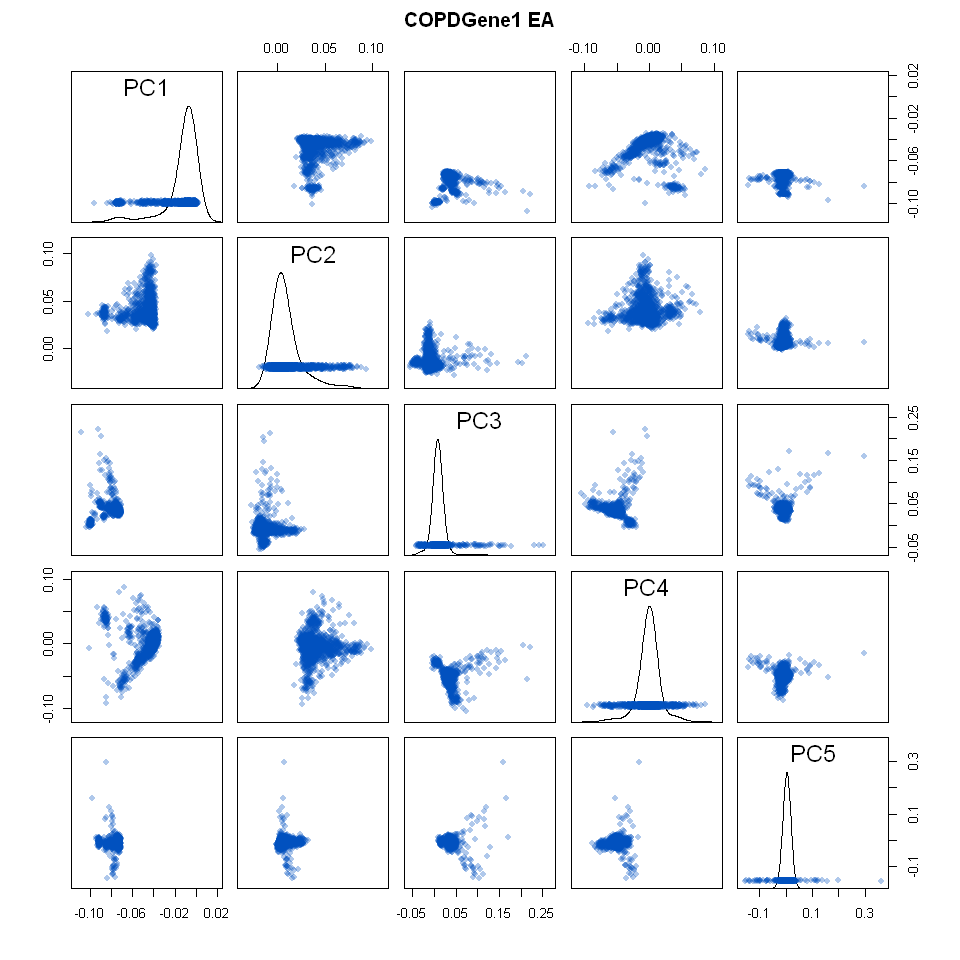

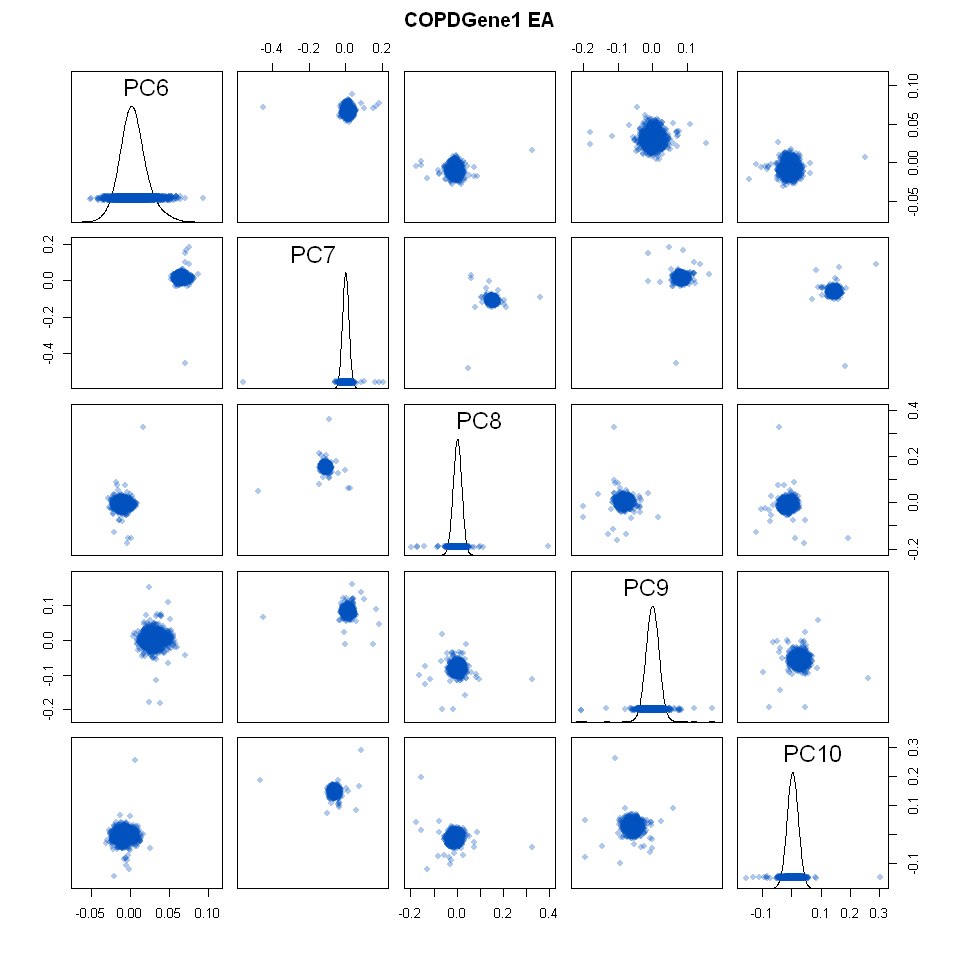

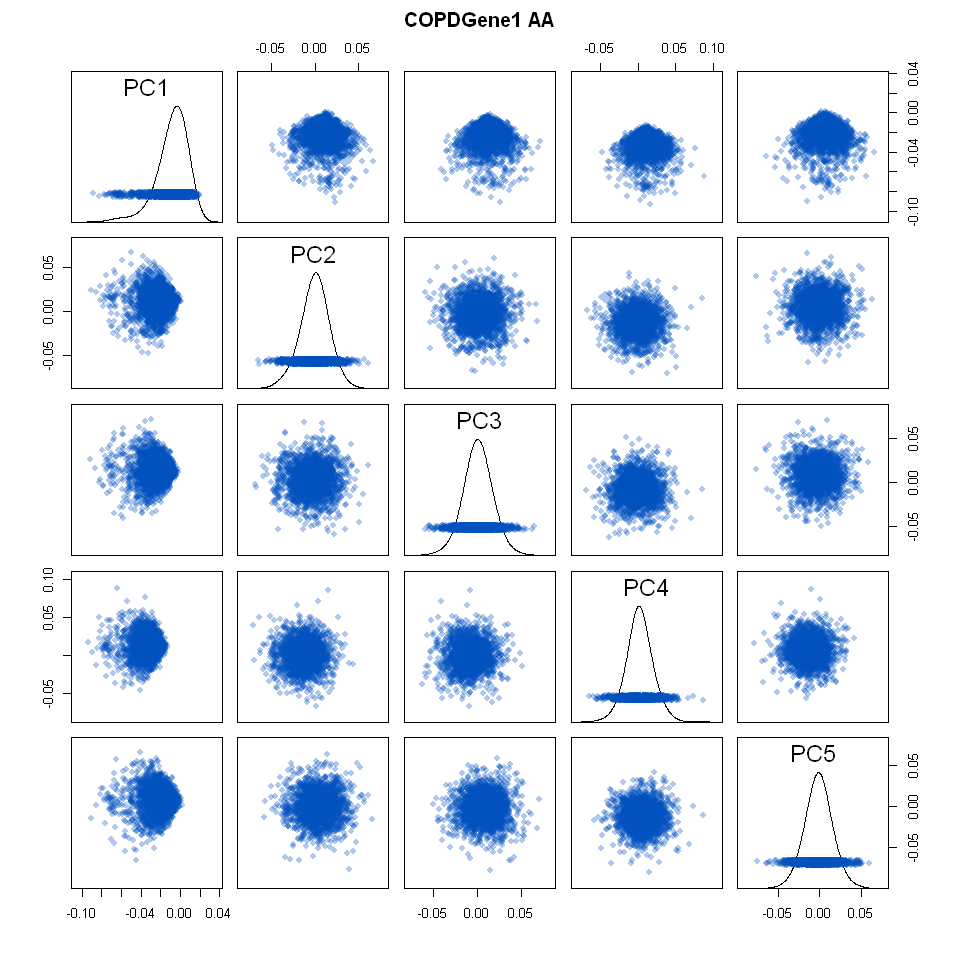

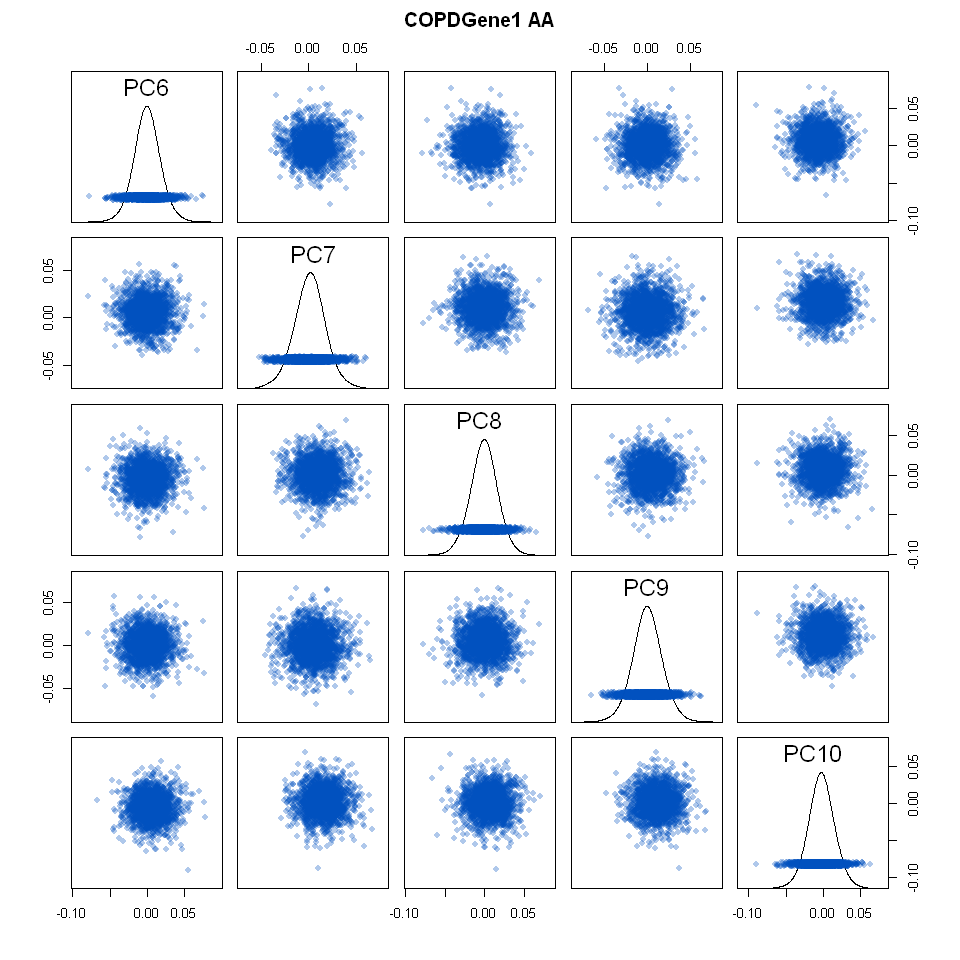

In [110]:
### R console ###

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance/
ea.dspace <- ea.evec[1:10] #transformed dataspace
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- ea.evec[,11]
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene1 EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene1 EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene1 AA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene1 AA", cex.main=1)


#### Extract eigenvectors

In [ ]:
## EC2 ##
cd /shared/s3/copdgene1/eigenstrat/results

# Grab top 10 eigenvectors from PCA 
for ancestry in {"ea","aa"}; do
    # Extract eigenvectors
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > ${ancestry}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 ${ancestry}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> ${ancestry}_ld_pruned_top10_eigenvecs.txt
done

### EA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.

**Note**: we will perform this on our local machine for convenience.

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/eigenstrat
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene1/eigenstrat/results/ea_ld_pruned_top10_eigenvecs.txt .
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene1/eigenstrat/results/aa_ld_pruned_top10_eigenvecs.txt .

#### Create PED files 
The covariates we want to include are `sex`,`age`, and `gold status` and some of the most influential PCs. Sex is encoded as 1=Male and 2=Female in these phenotype data. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain $\sim75\%$ of the variance.

In [ ]:
# split phenotype file up by race
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one

head -n 1 phenotype.ftnd.fg.sex.age1.filtered.txt > ea.phenotype.data
awk 'NR>=2 {if ($3==1) {print $0}}' phenotype.ftnd.fg.sex.age1.filtered.txt >> ea.phenotype.data

In [113]:
### R (local) ###

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one/")
p.data.ea <- "ea.phenotype.data"
pheno.data.ea <- read.csv(p.data.ea, sep = " ", header = T, stringsAsFactors = F, 
                       colClasses=c("character", "integer", "integer","double",
                                    "integer","integer","integer", "integer"))
head(pheno.data.ea)
pca.data.ea <- read.csv("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/eigenstrat/ea_ld_pruned_top10_eigenvecs.txt",
                        sep = " " , header = T, 
                        colClasses=c(rep("character",times=2), rep("double",times = 10)))
head(pca.data.ea)

num.subjects.ea <- length(pca.data.ea[,1])

header.names <- c("fid", "iid", "patid", "matid", "sex", "age", "goldneg1", "gold1or2", "gold3or4", "ftnd")
ped.file.ea <- data.frame(matrix(ncol = length(header.names), nrow = num.subjects.ea))
colnames(ped.file.ea) <- header.names
ped.file.ea[,1] <- pca.data.ea[,1]
ped.file.ea[,2] <- pca.data.ea[,1] # will the iid be the same as the fid?

# map loop (goal to fill in sex, age, ftnd, and gold status data on ped.file from the pheno.data)
for (i in 1:num.subjects.ea){
    key <- noquote(ped.file.ea[i,2])
    
    my_match <- match(key, pheno.data.ea[,1])
    ped.file.ea[i,5] <- pheno.data.ea[my_match,2]# sex
    ped.file.ea[i,6] <- pheno.data.ea[my_match,4] # age
    ped.file.ea[i,7] <- pheno.data.ea[my_match,6] # goldneg1
    ped.file.ea[i,8] <- pheno.data.ea[my_match,7] # gold1or2
    ped.file.ea[i,9] <- pheno.data.ea[my_match,8] # gold3or4
    ped.file.ea[i,10] <- pheno.data.ea[my_match,5] # ftnd
    
} # end i loop
head(ped.file.ea)

write.table(ped.file.ea, "COPDGene1_EUR_phen.ped", sep = "\t", row.names = F, quote=F)

#----------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude ftnd data)
col.names.ea <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "goldneg1", "gold1or2", "gold3or4", "PC1", "PC2",
                  "PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.ea <- length(col.names.ea)
covar.data.ea <- data.frame(matrix(ncol = num.columns.ea, nrow = num.subjects.ea))
names(covar.data.ea) <- col.names.ea
num.covs.ea <- length(ped.file.ea) - 1
covar.data.ea[,1:num.covs.ea] <- ped.file.ea[,1:num.covs.ea]

covar.data.ea[,(num.covs.ea+1):length(col.names.ea)] <- pca.data.ea[,3:length(pca.data.ea)]

head(covar.data.ea)
length(covar.data.ea[,1])

write.table(covar.data.ea, "COPDGene1_EUR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

sid    gender race age_p1 CurFTND_cat_p1 Goldneg1 Gold1or2 Gold3or4
1 10008W 1      1    55.1   0              1        0        0       
2 10248Q 1      1    66.9   2              1        0        0       
3 10521I 2      1    53.3   1              1        0        0       
4 10604M 2      1    64.9   1              1        0        0       
5 10705S 2      1    70.6   0              1        0        0       
6 10918J 2      1    54.0   1              1        0        0

FID    IID    EV1    EV2     EV3     EV4     EV5     EV6    EV7     EV8    
1 10005Q 10005Q 0.0069 -0.0087 -0.0074 -0.0020  0.0318 0.0029 -0.0141 -0.0055
2 10010J 10010J 0.0032 -0.0020 -0.0054 -0.0084 -0.0010 0.0081 -0.0040  0.0102
3 10028C 10028C 0.0153  0.0770 -0.0096  0.0042  0.0180 0.0175  0.0048 -0.0103
4 10031R 10031R 0.0139 -0.0105 -0.0052 -0.0039  0.0176 0.0110  0.0111 -0.0232
5 10041U 10041U 0.0112 -0.0091 -0.0063 -0.0066 -0.0127 0.0153 -0.0070  0.0121
6 10051X 10051X 0.0176 -0.0251 -0.0130  0.0129 -0.0201 0.0594 -0.0257  0.0074
  EV9     EV10   
1 -0.0185  0.0034
2  0.0108 -0.0121
3 -0.0081 -0.0073
4  0.0360  0.0044
5 -0.0068  0.0036
6  0.0070 -0.0115

fid    iid    patid matid sex age  goldneg1 gold1or2 gold3or4 ftnd
1 10005Q 10005Q NA    NA    2   54.5 0        0        0        1   
2 10010J 10010J NA    NA    2   65.9 0        0        1        0   
3 10028C 10028C NA    NA    1   61.8 0        1        0        0   
4 10031R 10031R NA    NA    1   60.9 0        1        0        1   
5 10041U 10041U NA    NA    1   63.4 0        0        1        0   
6 10051X 10051X NA    NA    2   54.3 0        1        0        1

fid    iid    patid matid sex age  goldneg1 gold1or2 gold3or4 PC1    PC2    
1 10005Q 10005Q NA    NA    2   54.5 0        0        0        0.0069 -0.0087
2 10010J 10010J NA    NA    2   65.9 0        0        1        0.0032 -0.0020
3 10028C 10028C NA    NA    1   61.8 0        1        0        0.0153  0.0770
4 10031R 10031R NA    NA    1   60.9 0        1        0        0.0139 -0.0105
5 10041U 10041U NA    NA    1   63.4 0        0        1        0.0112 -0.0091
6 10051X 10051X NA    NA    2   54.3 0        1        0        0.0176 -0.0251
  PC3     PC4     PC5     PC6    PC7     PC8     PC9     PC10   
1 -0.0074 -0.0020  0.0318 0.0029 -0.0141 -0.0055 -0.0185  0.0034
2 -0.0054 -0.0084 -0.0010 0.0081 -0.0040  0.0102  0.0108 -0.0121
3 -0.0096  0.0042  0.0180 0.0175  0.0048 -0.0103 -0.0081 -0.0073
4 -0.0052 -0.0039  0.0176 0.0110  0.0111 -0.0232  0.0360  0.0044
5 -0.0063 -0.0066 -0.0127 0.0153 -0.0070  0.0121 -0.0068  0.0036
6 -0.0130  0.0129 -0.0201 0.0594 -0.0257  0.0074  0.0070 -0.0115

[1] 2549

In [114]:
### R console ###

# Load PCA data
setwd('C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one/')
options(stringsAsFactors=F)
ea.cov.data <- read.delim("COPDGene1_EUR_cov.ped", header=T, sep="\t")
ea.phen.data <- read.delim("COPDGene1_EUR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "ftnd"
pc.names <- paste0("PC", 1:10)
ea.data <- merge(x=ea.phen.data[,c("iid",phen.name)], y=ea.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(ea.data)

iid    ftnd PC1    PC2     PC3     PC4     PC5     PC6    PC7     PC8    
1 10005Q 1    0.0069 -0.0087 -0.0074 -0.0020  0.0318 0.0029 -0.0141 -0.0055
2 10010J 0    0.0032 -0.0020 -0.0054 -0.0084 -0.0010 0.0081 -0.0040  0.0102
3 10028C 0    0.0153  0.0770 -0.0096  0.0042  0.0180 0.0175  0.0048 -0.0103
4 10031R 1    0.0139 -0.0105 -0.0052 -0.0039  0.0176 0.0110  0.0111 -0.0232
5 10041U 0    0.0112 -0.0091 -0.0063 -0.0066 -0.0127 0.0153 -0.0070  0.0121
6 10051X 1    0.0176 -0.0251 -0.0130  0.0129 -0.0201 0.0594 -0.0257  0.0074
  PC9     PC10   
1 -0.0185  0.0034
2  0.0108 -0.0121
3 -0.0081 -0.0073
4  0.0360  0.0044
5 -0.0068  0.0036
6  0.0070 -0.0115

#### Regression analysis
We use a regression model of the general structure $$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [115]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.ea <- lm(formula=as.formula(model.str), data=ea.data)

# Get sequential (type I) sum of squares
anova.ea <- anova(lm.fit.ea)

# Calculate percent variance explained and sort
ea.pve <- cbind(anova.ea[pc.names,], 
                PVE=round(anova.ea[pc.names, "Mean Sq"]/sum(anova.ea[pc.names, "Mean Sq"])*100, digits=2))
ea.pve.sorted <- ea.pve[order(ea.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ EA group ================")
summary(lm.fit.ea)
ea.pve.sorted

MODEL FORMULA:

 ftnd ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EA group ================


Call:
lm(formula = as.formula(model.str), data = ea.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2618 -0.9335  0.0212  0.9707  1.1586 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.97842    0.01483  65.964   <2e-16 ***
PC1          0.38037    0.74884   0.508    0.612    
PC2         -0.75472    0.74888  -1.008    0.314    
PC3          1.86165    0.74885   2.486    0.013 *  
PC4          0.46348    0.74889   0.619    0.536    
PC5         -0.06664    0.74888  -0.089    0.929    
PC6          0.29754    0.74888   0.397    0.691    
PC7          0.53155    0.74886   0.710    0.478    
PC8         -0.31581    0.74884  -0.422    0.673    
PC9          0.85473    0.74887   1.141    0.254    
PC10         0.95201    0.74890   1.271    0.204    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7489 on 2538 degrees of freedom
Multiple R-squared:  0.004551,	Adjusted R-squared:  0.0006292 
F-stat

Df Sum Sq      Mean Sq     F value     Pr(>F)     PVE  
PC3  1  3.466383107 3.466383107 6.181160177 0.01297563 53.27
PC10 1  0.906230599 0.906230599 1.615965783 0.20377171 13.93
PC9  1  0.730654620 0.730654620 1.302883467 0.25379488 11.23
PC2  1  0.569673001 0.569673001 1.015825418 0.31360736  8.75
PC7  1  0.282521909 0.282521909 0.503785392 0.47790676  4.34
PC4  1  0.214779178 0.214779178 0.382988396 0.53606376  3.30
PC1  1  0.144701465 0.144701465 0.258027721 0.61152253  2.22
PC8  1  0.099731089 0.099731089 0.177837768 0.67327377  1.53
PC6  1  0.088470325 0.088470325 0.157757880 0.69126263  1.36
PC5  1  0.004445061 0.004445061 0.007926313 0.92906522  0.07

#### Percent Variance Explained Visualization

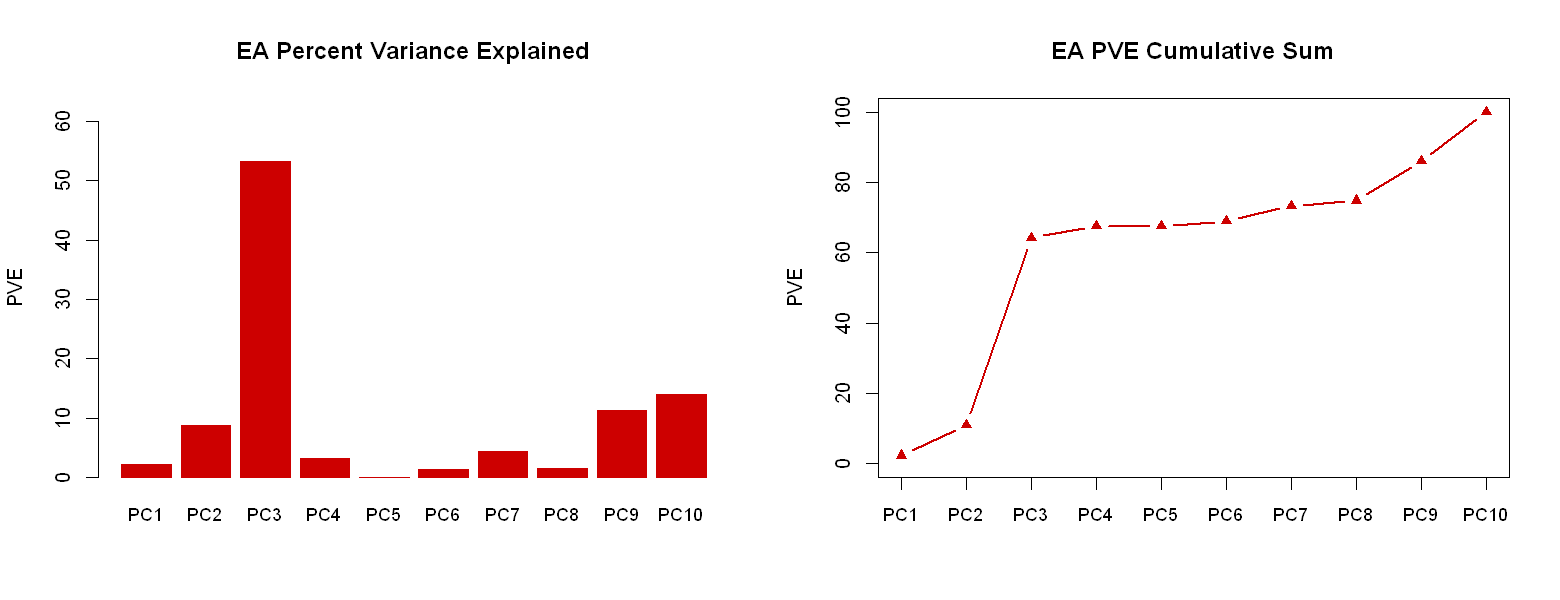

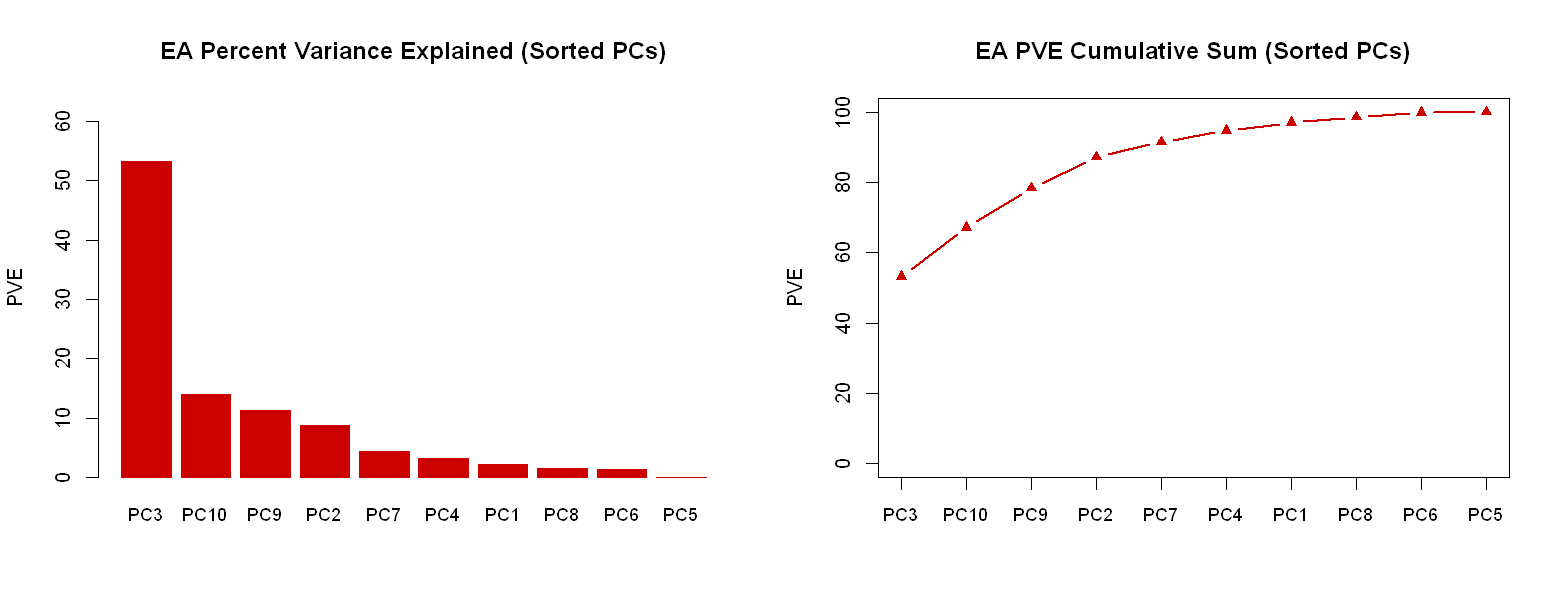

In [116]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.ea = c(0, max(ea.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=ea.pve$PVE, names.arg=rownames(ea.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, 
        main="EA Percent Variance Explained", ylab="PVE")
plot(cumsum(ea.pve$PVE), type="b", main="EA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=ea.pve.sorted$PVE, names.arg=rownames(ea.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, main="EA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(ea.pve.sorted$PVE), type="b", main="EA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC3, PC10, and PC9. These PCs explain ~78% of the variance.

#### Construct a phenotype file for ProbABEL with PCs
* Need to include PC8, PC2, PC9, and PC7.
* Header needs to be

```
IID     CAT_FTND      SEX     EV3     EV10     EV9     
```

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one

# the IID in the phenotype file needs to be of the form "iid"
# to match the iid in the mldose file
ancestry=ea
awk 'BEGIN{} NR>=2{print $1}' COPDGene1_EUR_cov.ped > IID.${ancestry}.txt

In [123]:
### R console ###
setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one")

# read in data files
phen <- read.table("COPDGene1_EUR_phen.ped", header=T)
cov <- read.table("COPDGene1_EUR_cov.ped", header=T)
iid <- read.table("IID.ea.txt", header=F)
num.subjects <- length(iid[,1])
num.subjects

# create data frame to combine those files
covar.names <- c("IID", "CAT_FTND", "SEX", "AGE", "GOLDNEG1", 
                       "GOLD1OR2", "GOLD3OR4", "EV3", "EV10", "EV9")
covar.data <- data.frame(matrix(ncol = length(covar.names), nrow = num.subjects))
names(covar.data) <- covar.names
covar.data[1] <- iid[1]
covar.data[2] <- phen[10]
covar.data[3] <- phen[5]
covar.data[4] <- phen[6]
covar.data[5] <- phen[7]
covar.data[6] <- phen[8]
covar.data[7] <- phen[9]
# PCs
covar.data[8] <- cov[12]
covar.data[9] <- cov[19]
covar.data[10] <- cov[18]
head(covar.data)

write.table(x = covar.data, file = "copdgene1.ea.CAT_FTND.SEX.AGE.GOLD.EVs", quote = F, row.names = F)

[1] 2549

IID    CAT_FTND SEX AGE  GOLDNEG1 GOLD1OR2 GOLD3OR4 EV3     EV10    EV9    
1 10005Q 1        2   54.5 0        0        0        -0.0074  0.0034 -0.0185
2 10010J 0        2   65.9 0        0        1        -0.0054 -0.0121  0.0108
3 10028C 0        1   61.8 0        1        0        -0.0096 -0.0073 -0.0081
4 10031R 1        1   60.9 0        1        0        -0.0052  0.0044  0.0360
5 10041U 0        1   63.4 0        0        1        -0.0063  0.0036 -0.0068
6 10051X 1        2   54.3 0        1        0        -0.0130 -0.0115  0.0070

### AA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.

**Note**: we will perform this on our local machine for convenience.

#### Create PED files 
The covariates we want to include are `sex`,`age`, and `gold status` and some of the most influential PCs. Sex is encoded as 1=Male and 2=Female in these phenotype data. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain $\sim75\%$ of the variance.

In [ ]:
## local console  ##
# split phenotype file up by race
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one

head -n 1 phenotype.ftnd.fg.sex.age1.filtered.txt > aa.phenotype.data
awk 'NR>=2 {if ($3==2) {print $0}}' phenotype.ftnd.fg.sex.age1.filtered.txt >> aa.phenotype.data

In [127]:
### R (local) ###

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one/")
p.data.aa <- "aa.phenotype.data"
pheno.data.aa <- read.csv(p.data.aa, sep = " ", header = T, stringsAsFactors = F, 
                       colClasses=c("character", "integer", "integer","double",
                                    "integer","integer","integer", "integer"))
head(pheno.data.aa)
pca.data.aa <- read.csv("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/eigenstrat/aa_ld_pruned_top10_eigenvecs.txt", sep = " " , 
                    colClasses=c(rep("character",times=2), rep("double",times = 10)))
head(pca.data.aa)

num.subjects.aa <- length(pca.data.aa[,1])

header.names <- c("fid", "iid", "patid", "matid", "sex", "age", "goldneg1", "gold1or2", "gold3or4", "ftnd")
ped.file.aa <- data.frame(matrix(ncol = length(header.names), nrow = num.subjects.aa))
colnames(ped.file.aa) <- header.names
ped.file.aa[,1] <- pca.data.aa[,1]
ped.file.aa[,2] <- pca.data.aa[,1] # will the iid be the same as the fid?

# map loop (goal to fill in sex, age, ftnd, and gold status data on ped.file from the pheno.data)
for (i in 1:num.subjects.aa){
    key <- noquote(ped.file.aa[i,2])
    
    my_match <- match(key, pheno.data.aa[,1])
    ped.file.aa[i,5] <- pheno.data.aa[my_match,2]# sex
    ped.file.aa[i,6] <- pheno.data.aa[my_match,4] # age
    ped.file.aa[i,7] <- pheno.data.aa[my_match,6] # goldneg1
    ped.file.aa[i,8] <- pheno.data.aa[my_match,7] # gold1or2
    ped.file.aa[i,9] <- pheno.data.aa[my_match,8] # gold3or4
    ped.file.aa[i,10] <- pheno.data.aa[my_match,5] # ftnd
    
} # end i loop
head(ped.file.aa)
#
write.table(ped.file.aa, "COPDGene1_AA_phen.ped", sep = "\t", row.names = F, quote=F)
#
##----------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude ftnd data)
col.names.aa <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "goldneg1", "gold1or2", "gold3or4", "PC1", "PC2",
                  "PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.aa <- length(col.names.aa)
covar.data.aa <- data.frame(matrix(ncol = num.columns.aa, nrow = num.subjects.aa))
names(covar.data.aa) <- col.names.aa
num.covs.aa <- length(ped.file.aa) - 1
covar.data.aa[,1:num.covs.aa] <- ped.file.aa[,1:num.covs.aa]

covar.data.aa[,(num.covs.aa+1):length(covar.data.aa)] <- pca.data.aa[,3:length(pca.data.aa)]
head(covar.data.aa)
length(covar.data.aa[,1])

write.table(covar.data.aa, "COPDGene1_AA_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

sid    gender race age_p1 CurFTND_cat_p1 Goldneg1 Gold1or2 Gold3or4
1 10181K 2      2    58.1   0              1        0        0       
2 10185S 1      2    49.6   0              1        0        0       
3 10365U 2      2    52.8   1              1        0        0       
4 10642U 1      2    70.8   1              1        0        0       
5 10702M 1      2    53.4   0              1        0        0       
6 10744C 2      2    50.1   1              1        0        0

FID    IID    EV1     EV2     EV3     EV4     EV5     EV6     EV7     EV8    
1 10067M 10067M -0.0522  0.0005  0.0581 -0.0003 -0.0475 -0.0008 -0.0281 -0.0019
2 10096T 10096T -0.0016  0.0097  0.0171 -0.0107 -0.0083  0.0372  0.0113 -0.0149
3 10168S 10168S -0.0017 -0.0144  0.0457  0.0035  0.0015  0.0246 -0.0168  0.0201
4 10181K 10181K  0.0201  0.0036 -0.0038 -0.0205 -0.0154  0.0017  0.0070 -0.0093
5 10185S 10185S  0.0149  0.0061 -0.0096  0.0051 -0.0058  0.0043  0.0061  0.0253
6 10228K 10228K  0.0041  0.0171 -0.0388 -0.0109 -0.0162 -0.0020 -0.0085 -0.0272
  EV9     EV10   
1 -0.0051 -0.0276
2  0.0086 -0.0340
3 -0.0078 -0.0347
4  0.0077 -0.0082
5 -0.0160  0.0037
6  0.0373 -0.0051

fid    iid    patid matid sex age  goldneg1 gold1or2 gold3or4 ftnd
1 10067M 10067M NA    NA    2   45.5 0        0        0        1   
2 10096T 10096T NA    NA    2   47.8 0        0        1        1   
3 10168S 10168S NA    NA    1   47.5 0        0        0        1   
4 10181K 10181K NA    NA    2   58.1 1        0        0        0   
5 10185S 10185S NA    NA    1   49.6 1        0        0        0   
6 10228K 10228K NA    NA    1   59.7 0        1        0        2

fid    iid    patid matid sex age  goldneg1 gold1or2 gold3or4 PC1     PC2    
1 10067M 10067M NA    NA    2   45.5 0        0        0        -0.0522  0.0005
2 10096T 10096T NA    NA    2   47.8 0        0        1        -0.0016  0.0097
3 10168S 10168S NA    NA    1   47.5 0        0        0        -0.0017 -0.0144
4 10181K 10181K NA    NA    2   58.1 1        0        0         0.0201  0.0036
5 10185S 10185S NA    NA    1   49.6 1        0        0         0.0149  0.0061
6 10228K 10228K NA    NA    1   59.7 0        1        0         0.0041  0.0171
  PC3     PC4     PC5     PC6     PC7     PC8     PC9     PC10   
1  0.0581 -0.0003 -0.0475 -0.0008 -0.0281 -0.0019 -0.0051 -0.0276
2  0.0171 -0.0107 -0.0083  0.0372  0.0113 -0.0149  0.0086 -0.0340
3  0.0457  0.0035  0.0015  0.0246 -0.0168  0.0201 -0.0078 -0.0347
4 -0.0038 -0.0205 -0.0154  0.0017  0.0070 -0.0093  0.0077 -0.0082
5 -0.0096  0.0051 -0.0058  0.0043  0.0061  0.0253 -0.0160  0.0037
6 -0.0388 -0.0109 -0.0162 -0.0020 -0.0085 -0.0272  0.0373 -0.0051

[1] 2534

In [128]:
### R console ###

# Load PCA data
setwd('C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one/')
options(stringsAsFactors=F)
aa.cov.data <- read.delim("COPDGene1_AA_cov.ped", header=T, sep="\t")
aa.phen.data <- read.delim("COPDGene1_AA_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "ftnd"
pc.names <- paste0("PC", 1:10)
aa.data <- merge(x=aa.phen.data[,c("iid",phen.name)], y=aa.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(aa.data)

iid    ftnd PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8    
1 10067M 1    -0.0522  0.0005  0.0581 -0.0003 -0.0475 -0.0008 -0.0281 -0.0019
2 10096T 1    -0.0016  0.0097  0.0171 -0.0107 -0.0083  0.0372  0.0113 -0.0149
3 10168S 1    -0.0017 -0.0144  0.0457  0.0035  0.0015  0.0246 -0.0168  0.0201
4 10181K 0     0.0201  0.0036 -0.0038 -0.0205 -0.0154  0.0017  0.0070 -0.0093
5 10185S 0     0.0149  0.0061 -0.0096  0.0051 -0.0058  0.0043  0.0061  0.0253
6 10228K 2     0.0041  0.0171 -0.0388 -0.0109 -0.0162 -0.0020 -0.0085 -0.0272
  PC9     PC10   
1 -0.0051 -0.0276
2  0.0086 -0.0340
3 -0.0078 -0.0347
4  0.0077 -0.0082
5 -0.0160  0.0037
6  0.0373 -0.0051

#### Regression analysis
We use a regression model of the general structure $$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [129]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.aa <- lm(formula=as.formula(model.str), data=aa.data)

# Get sequential (type I) sum of squares
anova.aa <- anova(lm.fit.aa)

# Calculate percent variance explained and sort
aa.pve <- cbind(anova.aa[pc.names,], 
                PVE=round(anova.aa[pc.names, "Mean Sq"]/sum(anova.aa[pc.names, "Mean Sq"])*100, digits=2))
aa.pve.sorted <- aa.pve[order(aa.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ AA group ================")
summary(lm.fit.aa)
aa.pve.sorted

MODEL FORMULA:

 ftnd ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AA group ================


Call:
lm(formula = as.formula(model.str), data = aa.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.14745 -0.92511  0.01384  0.93993  1.18519 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.98540    0.01469  67.099   <2e-16 ***
PC1         -0.28503    0.73926  -0.386    0.700    
PC2         -1.09416    0.73922  -1.480    0.139    
PC3          0.34701    0.73927   0.469    0.639    
PC4         -0.83943    0.73925  -1.136    0.256    
PC5          0.14987    0.73923   0.203    0.839    
PC6          0.78682    0.73926   1.064    0.287    
PC7          0.45849    0.73925   0.620    0.535    
PC8         -1.18542    0.73924  -1.604    0.109    
PC9         -0.99198    0.73928  -1.342    0.180    
PC10        -0.51711    0.73930  -0.699    0.484    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7393 on 2523 degrees of freedom
Multiple R-squared:  0.004054,	Adjusted R-squared:  0.00010

Df Sum Sq     Mean Sq    F value   Pr(>F)    PVE  
PC8  1  1.40532200 1.40532200 2.5714423 0.1089337 25.04
PC2  1  1.19731996 1.19731996 2.1908425 0.1389582 21.34
PC9  1  0.98398965 0.98398965 1.8004931 0.1797736 17.53
PC4  1  0.70478778 0.70478778 1.2896127 0.2562272 12.56
PC6  1  0.61909681 0.61909681 1.1328163 0.2872773 11.03
PC10 1  0.26738285 0.26738285 0.4892541 0.4843247  4.76
PC7  1  0.21002035 0.21002035 0.3842929 0.5353707  3.74
PC3  1  0.12035445 0.12035445 0.2202232 0.6389104  2.14
PC1  1  0.08127430 0.08127430 0.1487148 0.6997991  1.45
PC5  1  0.02244669 0.02244669 0.0410727 0.8394140  0.40

#### Percent Variance Explained Visualization

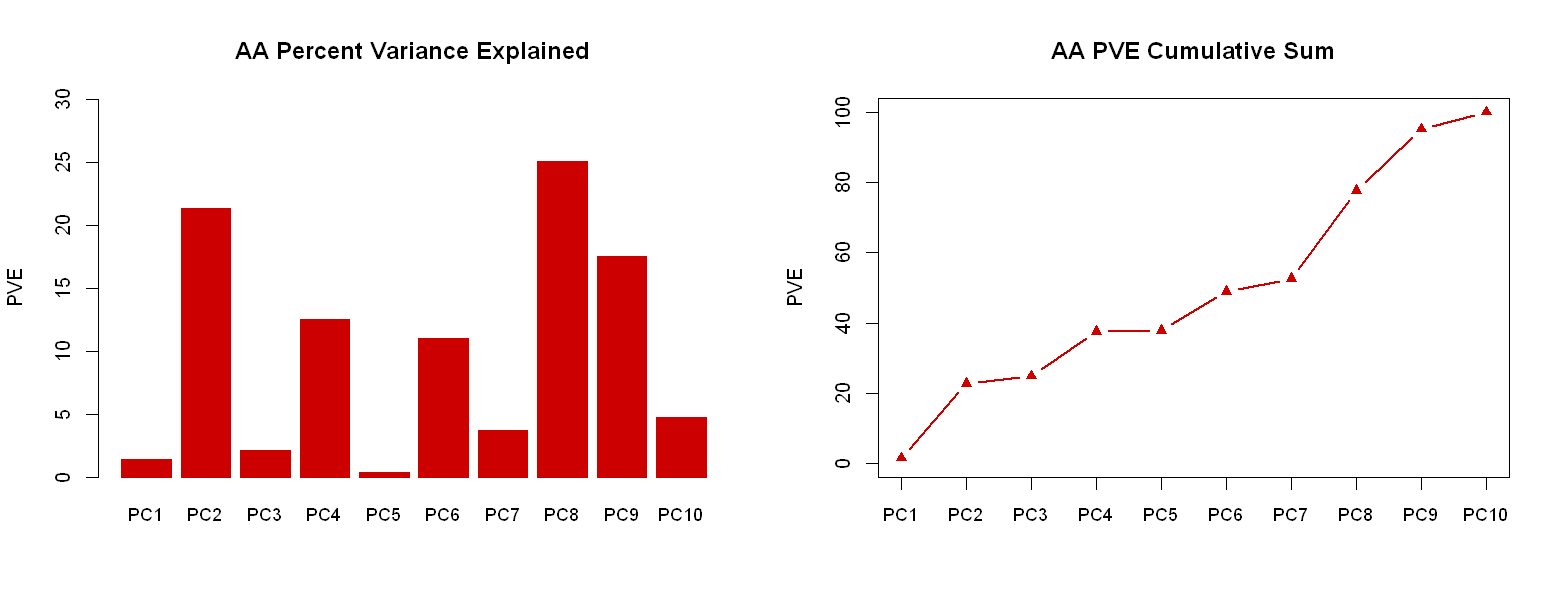

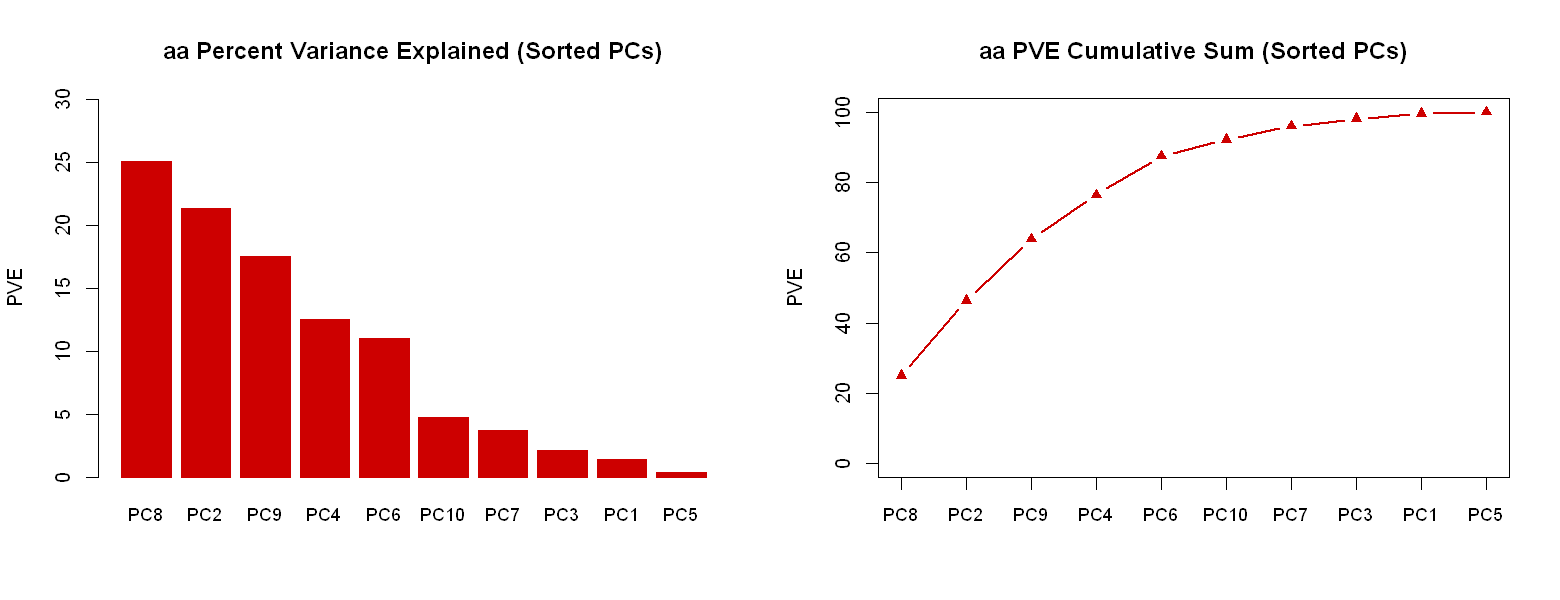

In [130]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.aa = c(0, max(aa.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=aa.pve$PVE, names.arg=rownames(aa.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, 
        main="AA Percent Variance Explained", ylab="PVE")
plot(cumsum(aa.pve$PVE), type="b", main="AA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=aa.pve.sorted$PVE, names.arg=rownames(aa.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, main="aa Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(aa.pve.sorted$PVE), type="b", main="aa PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC8, PC2, PC9, and PC4. These PCs explain ~76% of the variance.

#### Construct a phenotype file for ProbABEL with PCs
* Need to include PC8, PC2, PC9, and PC4.
* Header needs to be

```
IID     CAT_FTND      SEX     EV8     EV2     EV9     EV4
```

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one

# the IID in the phenotype file needs to be of the form "iid"
# to match the iid in the mldose file
awk 'BEGIN{} NR>=2{print $1}' COPDGene1_AA_cov.ped > IID.aa.txt

In [132]:
### R console ###
setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one")

# read in data files
phen <- read.table("COPDGene1_AA_phen.ped", header=T)
cov <- read.table("COPDGene1_AA_cov.ped", header=T)
iid <- read.table("IID.aa.txt", header=F)
num.subjects <- length(iid[,1])
num.subjects

# create data frame to combine those files
covar.names <- c("IID", "CAT_FTND", "SEX", "AGE", "GOLDNEG1", 
                       "GOLD1OR2", "GOLD3OR4", "EV3", "EV5", "EV2", "EV8", "EV10")
covar.data <- data.frame(matrix(ncol = length(covar.names), nrow = num.subjects))
names(covar.data) <- covar.names
covar.data[1] <- iid[1]
covar.data[2] <- phen[10]
covar.data[3] <- phen[5]
covar.data[4] <- phen[6]
covar.data[5] <- phen[7]
covar.data[6] <- phen[8]
covar.data[7] <- phen[9]
covar.data[8] <- cov[12]
covar.data[9] <- cov[14]
covar.data[10] <- cov[11]
covar.data[11] <- cov[17]
covar.data[12] <- cov[19]
head(covar.data)

write.table(x = covar.data, file = "copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs", quote = F, row.names = F)

[1] 2534

IID    CAT_FTND SEX AGE  GOLDNEG1 GOLD1OR2 GOLD3OR4 EV3     EV5     EV2    
1 10067M 1        2   45.5 0        0        0         0.0581 -0.0475  0.0005
2 10096T 1        2   47.8 0        0        1         0.0171 -0.0083  0.0097
3 10168S 1        1   47.5 0        0        0         0.0457  0.0015 -0.0144
4 10181K 0        2   58.1 1        0        0        -0.0038 -0.0154  0.0036
5 10185S 0        1   49.6 1        0        0        -0.0096 -0.0058  0.0061
6 10228K 2        1   59.7 0        1        0        -0.0388 -0.0162  0.0171
  EV8     EV10   
1 -0.0019 -0.0276
2 -0.0149 -0.0340
3  0.0201 -0.0347
4 -0.0093 -0.0082
5  0.0253  0.0037
6 -0.0272 -0.0051

### Transfer Phenotype Files 
This analysis is going to be performed on MIDAS. We will therefore have to transfer these EA and AA phenotype files that we created.

In [ ]:
## MIDAS ##

# create directory structure
mkdir -p ~/gwas/{association_tests,phenotype/{processing,final}}

In [ ]:
## local command line ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/pheno/one

scp copdgene1.* jmarks@rtplhpc01.rti.ns:~/gwas/copdgene1/phenotype/processing

## Genotype Data COPDGene1
The genotype data have been imputed on the in-house computing cluster MIDAS using impute2. IMPUTE2 is a computer program for phasing observed genotypes and imputing missing genotypes

The imputed data are split by chromosome and the chromosome data are further split into chunks. Because of this, we will incorporate the Nextflow pipeline that has already been established. 

# ProbABEL Analysis with Nextflow
We try out ProbABEL as integrated into [Nextflow](https://www.nextflow.io/). Nextflow allows you to write a computational pipeline by making it simpler to put together many different tasks. 

* For the analysis, I will need the script: `_pipeline.association.out_stats_files.run.sh` and `nextflow.config`.

* To generate the plots I will need: `_methods.cogend.imputed.v3.association_tests.006.sh`

These scripts were copied to my working directory from an example directory on MIDAS at the location:

`/share/nas04/bioinformatics_group/data/studies/jhs_aric_aa/imputed/v3/association_tests/001`

## Scripts to run analysis
These scripts should be placed in the working directory. For this analysis on MIDAS, the working directory they were placed in was `/home/jmarks/gwas/copdgene1`
#### pipeline script

In [ ]:
#!/bin/sh

for ancestry in {ea,aa}; do
    working_dir=/share/nas04/jmarks/gwas/copdgene1/association_tests/002/${ancestry}
    imputation_root=/share/nas03/bioinformatics_group/data/studies/copdgene/imputed/v3/imputations/
    # path to phenotype file created in the section above
    phenotype_root=/share/nas04/jmarks/gwas/copdgene1/phenotype/processing 

    method=palinear # GWAS method

    for (( chr=1; chr<24; chr++ )); do
        out_file=copdgene1.${ancestry}.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.stats
        phenotype_file=copdgene1.${ancestry}.CAT_FTND.SEX.AGE.GOLD.EVs
        geno_prefix=copdgene.${ancestry}.1000G_p3.chr

        /share/nas03/bioinformatics_group/software/nextflow/nextflow-0.25.1-all \
        /share/nas03/bioinformatics_group/software/pipeline/_pipeline.association.out_stats_files.v0.1.nf \
            --final_chunks $imputation_root/chunks/final_chunks.chr$chr \
            --input_pheno $phenotype_root/$phenotype_file \
            --imputation_dir $imputation_root/${ancestry}/chr$chr \
            --example_mldose $imputation_root/${ancestry}/chr$chr/copdgene.${ancestry}.1000G_p3.chr$chr.2.mach.mldose.gz \
            --geno_prefix $geno_prefix \
            --working_dirs $working_dir \
            --out $working_dir/$out_file \
            --method $method

        rm -r $working_dir/../work
    done
done


#### nextflow.config

In [ ]:
## MIDAS ##
cd /share/nas04/jmarks/gwas/copdgene1/associtation_tests/001/

cat nextflow.config
"""
process.executor = 'sge'
process.clusterOptions = '-S /bin/bash'
"""

**Inspect Chr15**

In [ ]:
## local console ##
mkdir -p /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/results
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/results

scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene1/association_tests/002/ea/* .
scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene1/association_tests/002/aa/* .


# Capture missing data
While running the association analysis, there were a few errors. The EA subjects finished without a hitch. 
The AA subjects produced some errors. Specifically, chromosomes 1 and 5 threw some errors and did not finish. 
We need to redo:

* chr1 chunk 92
* chr5 chunk 9

I will specify these missing data in a file called `failed_chunks`, which should have the contents:

`
failed_chunks_convert
1       92
5       9`

Gzip the mldose file that was created. 

Attempt Nextflow pipeline again.

# Filter Results and Plot
This scripts should be placed in the working directory. For this analysis on MIDAS, the working directory they were placed in was `/share/nas04/jmarks/gwas/copdgene1/association_tests/001`.

`_methods.copdgene1.imputed.v1.association_tests.sh`

We will apply the filters
* MAF > 0.01
* and Rsq > 0.3

to the results of the GWAS analysis. Once the results are filtered, we will generate a [quantile-quantile (QQ) plot](http://physiology.med.cornell.edu/people/banfelder/qbio/resources_2013/2013_1_Mezey.pdf) as well as a [Manhattan plot](https://www.sciencedirect.com/topics/medicine-and-dentistry/manhattan-plot).

**Note**: The script below should be modified for each cohort and/or ancestry group. For example:
* line 2 and line 194 should be changed to copdgene2 for that cohort
*  if running for both ancestry groups line 7 should be commented out while, line 6, 16, 29, 59, 66, 88, 110, 133, 172, 192,  should be uncommented out
* uncomment all of the end-loop *done* expressions that correspond to the above bullet-point example

Also note this is the legacy script designed for execution on the in-house MIDAS cluster. The paths should be modified as necessary for computing on different computing platforms.

In [ ]:
# ASSOCIATION_ROOT=/share/nas04/jmarks/gwas/copdgene1/association_tests/001
COHORT=copdgene1
MODEL=CAT_FTND~SNP+AGE+SEX+GOLD+EVs

# making directories to process the results
#for ancestry in {ea,aa}; do
ancestry=ea
    for (( chr=1; chr<24; chr++ )); do
        mkdir -p $ASSOCIATION_ROOT/$ancestry/processing/chr$chr
    done
    mkdir $ASSOCIATION_ROOT/$ancestry/final
#done
### START Filter ###

# add in chr id
#for ancestry in {ea,aa}; do

    for (( chr=1; chr<24; chr++ )); do
        inFile=$ASSOCIATION_ROOT/$ancestry/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.stats
        echo Processing $inFile
        outFile=$ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.stats
        echo -e "chr\tname\tposition\tA1\tA2\tFreq1\tMAF\tQuality\tRsq\tn\tMean_predictor_allele\tbeta_SNP_add\tsebeta_SNP_add\tchi2_SNP\tchi\tp\tor_95_percent_ci" > $outFile
        tail -n +1 $inFile |
          perl -slne '{ print join("\t", "$chr", "$_"); }' -- -chr="$chr" >> $outFile # pass rudamentary arg
    done
#done

# MAF > 0.01 in AFR (AA) or EUR (EA)
#for ancestry in {ea,aa};do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
    for (( chr=1; chr<24; chr++ )); do
      if [ $chr == "23" ]; then
        # this is a list of all of the variants that have a MAF less than 0.01. We will use this as a remove list.
        idList=/share/nas03/bioinformatics_group/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.maf_lte_0.01_$group
      else
        idList=/share/nas03/bioinformatics_group/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.maf_lte_0.01_$group
      fi
      /share/nas03/bioinformatics_group/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr} \
        --script_prefix $ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$group \
        --mem 3.8 \
        --priority 0 \
        --program /share/nas03/bioinformatics_group/software/perl/extract_rows.pl \
        --source $ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
        --id_list $idList \
        --out $ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$group \
        --header 0 \
        --id_column 1 \
        --remove
    done
#done

python /home/jmarks/monitor.py # report progress on jobs

#for ancestry in aa; do
# note the three question marks is a wildcard
  mv $ASSOCIATION_ROOT/$ancestry/processing/chr*/*.maf_gt_0.01_??? \
   $ASSOCIATION_ROOT/$ancestry/final
#done

# Filter out variants with MAF <= 0.01 in study
#for ancestry in {ea,aa}; do
    if [ $ancestry == "aa" ]; then
        group=afr
    else
        group=eur
    fi
    for (( chr=1; chr<24; chr++ )); do
        inFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$group
        outFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_${group}+$COHORT
        echo Processing $inFile
        head -n 1 $inFile > $outFile
        tail -n +2 $inFile |
            # ?: is a non-capturing group. Basically, This is skipping groups 1-6 and capturing
            # the 7th column which is the MAF column
            perl -lne '/^(?:\S+\s+){6}(\S+)/;
                        if ( $1 > 0.01) {
                            print;
                        }' >> $outFile
    done
#done

# Filter out variants with Rsq <= 0.3 in study
#for ancestry in {ea,aa}; do
    if [ $ancestry == "aa" ]; then
        group=afr
    else
        group=eur
    fi
    for (( chr=1; chr<24; chr++ )); do
    inFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_${group}+$COHORT
    outFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_${group}+$COHORT.rsq_gt_0.3
    echo Processing $inFile
    head -n 1 $inFile > $outFile
    tail -n +2 $inFile |
        perl -lne '/^(?:\S+\s+){8}(\S+)/;
                    if ( $1 > 0.3) {
                        print;
                    }' >> $outFile
    done
#done

### END Filter ###

### START Generate plots ###
#for ancestry in aa; do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}+$COHORT.rsq_gt_0.3; do
        outFile=$ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile
for (( chr=1; chr<24; chr++ )); do
    inFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$ext
    echo Processing $inFile
    tail -n +2 $inFile |
      perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){10}\s+(\S+)/;
                 if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                   print join("\t",$2,$1,$3,$6,"snp");
                 } else {
                   print join("\t",$2,$1,$3,$6,"indel");
                 }' >> $outFile
done
done
#done

#for ancestry in {ea,aa}; do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}+$COHORT.rsq_gt_0.3; do
/share/nas03/bioinformatics_group/software/scripts/qsub_job.sh \
  --job_name gwas_plots \
  --script_prefix $ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.plots \
  --mem 15 \
  --priority 0 \
  --program /share/nas03/bioinformatics_group/software/R/dev/generate_gwas_plots.v6.R \
  --in $ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.table \
  --in_chromosomes autosomal_nonPAR \
  --in_header \
  --out $ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext \
  --col_id VARIANT_ID \
  --col_chromosome CHR \
  --col_position POSITION \
  --col_p P \
  --col_variant_type TYPE \
  --generate_snp_indel_manhattan_plot \
  --manhattan_odd_chr_color red \
  --manhattan_even_chr_color blue \
  --manhattan_points_cex 1.5 \
  --generate_snp_indel_qq_plot \
  --qq_lines \
  --qq_points_bg black \
  --qq_lambda
done
#done

### END Generate plots ###


### START Filter by p-value ###

# MAF > 0.01 in AFR and EUR
#for ancestry in aa; do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}+$COHORT.rsq_gt_0.3; do
    outFile=$ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.p_lte_0.001
    head -n 1 $ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr1.$MODEL.maf_gt_0.01_$ext > \
      $outFile
    for (( chr=1; chr<24; chr++ )); do
      echo Processing ${ASSOCIATION_ROOT}/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$ext
      tail -n +2 $ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$ext |
        perl -lane 'if ($F[15] <= 0.001) { print; }' >> \
        $outFile
    done
done
#done

# Sort
#for (ancestry in c("ea","aa")){
for (ancestry in c("ea")){
        cohort="copdgene1"
        if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0('/share/nas04/jmarks/gwas/', cohort, '/association_tests/001/',
                              ancestry,'/processing/', cohort, '.',ancestry,
                              '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',
                              group,'.p_lte_0.001'), header = TRUE)
        dat = dat[order(dat$p),]
        write.csv(dat,
            file = paste0('/share/nas04/jmarks/gwas/',cohort,'/association_tests/001/',
                          ancestry,'/final/', cohort, '.',ancestry,'.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',
                          group,'.p_lte_0.001.csv'), row.names = FALSE)
    
    
        dat=read.table(paste0('/share/nas04/jmarks/gwas/', cohort,'/association_tests/001/',
                              ancestry,'/processing/', cohort, '.',ancestry,
                              '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',group,
                              '+', cohort, '.rsq_gt_0.3.p_lte_0.001'), header=TRUE)
        dat = dat[order(dat$p),]
        write.csv(dat,
                  file = paste0('/share/nas04/jmarks/gwas/', cohort, '/association_tests/001/',
                         ancestry,'/final/', cohort, '.', ancestry, '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',
                         group,'+',cohort,'.rsq_gt_0.3.p_lte_0.001.csv'), row.names = FALSE)
}

## END Filter by p-value ###                                                                                           

## monitor.py
This python script was used in the above filtering/plotting script to let the user know the status of the processing jobs.

Location: `/home/jmarks/monitor.py`

In [ ]:
import subprocess
from sys import stdout, argv
from time import sleep
def check():
    p = subprocess.Popen(['qstat'], stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    out, err = p.communicate()
    return len(out.split('\n')) - 3, out

rows, msg = check()

while(rows > 0):
    stdout.write("\r%d jobs remaining..............." % rows)
    if(len(argv) > 1 and argv[1] == "show"):
        stdout.write('/n/')
        stdout.write(msg)
    stdout.flush()
    sleep(10)
    rows, msg = check()
stdout.write("\n" + "Finished.\n")

## Copy Results to Local

In [ ]:
## local console ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/results/ea/figures
scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene1/association_tests/001/ea/final/*png .

cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/results/aa/figures
scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene1/association_tests/003/aa/final/*png .

cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/results/ea/
scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene1/association_tests/001/ea/final/*.csv .

cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene1/results/aa/
scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene1/association_tests/001/aa/processing/*001 .

# 20220514 update
It was discovered that chr16 results did not get properly uploaded to AWS S3 at:
`s3://rti-nd/gwas/copdgene1/results/categorical_ftnd/0001/afr/final_stats/copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr+copdgene1+RSQ.phase3ID.gz`
All that is present in this results file is the header. The mere fact that the file exists likely contributed to us not realizing that the results were empty. So we will reprocess the chr16 results, and go from there.

Once I get a chr16 result, be sure to perform a sanity check on some established results like chr15 for example.

## Phenotype data
We should be able to use the phenotype file that was previously used for this GWAS.
`s3://rti-nd/gwas/copdgene1/data/phenotype/`



In [ ]:
# sample size N=2534
mkdir -p /shared/jmarks/rti-nd/gwas/copdgene1/data/phenotype/0001/aa
cd /shared/jmarks/rti-nd/gwas/copdgene1/data/phenotype/0001/aa
aws s3 cp s3://rti-nd/gwas/copdgene1/data/phenotype/copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs .

In [ ]:
# Prepare phenotype file
#/home/ec2-user/bioinformatics/software/perl/utilities/prepare_probabel_files.pl \
#    --in_mldose $imputationRoot/ea/chr1/heroin_icghd.ea.1000G_p3.chr1.0.mach.mldose.gz \
#    --in_pheno $phenotypePath/nelson.ea.CAT_FTND.AGE.SEX.EVs.v1 \
#    --out_pheno $baseDir/phenotype/nelson.ea.CAT_FTND.AGE.SEX.EVs.v1


## Genotype Data COPDGene1

The genotype data have been imputed on the retired in-house computing cluster MIDAS using impute2. IMPUTE2 is a computer program for phasing observed genotypes and imputing missing genotypes.

The imputed data are split by chromosome and the chromosome data are further split into chunks. We previously implemented the Nextflow pipeline that had already been established. We will attempt to process the data without Nextflow though because we no longer have access to that pipeline.

In [ ]:
# Download data
mkdir -p /shared/jmarks/rti-nd/gwas/copdgene1/data/genotype/imputed/aa/chr16/probabel_formatted/
cd /shared/jmarks/rti-nd/gwas/copdgene1/data/genotype/imputed/aa/chr16/
aws s3 sync s3://rti-nd/gwas/copdgene1/data/genotype/imputed/aa/chr16/ .


## Prepare Files 

### Prune MaCH files
The converted genotype data (mach format) files need to be reorder and pruned to match the subjects in the phenotype file. Pg. 7 of the [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) (or try [this link](https://people.montefiore.uliege.be/kvansteen/GBIO0009-1/ac20102011/Class8/ProbABELmanual.pdf)) reports that the genomic predictor file—which is the dosage file—has in the first column a sequential ID, followed by an arrow followed by the study ID.

We will first get a list of the IDs from the phenotype file.

In [ ]:
phenD=/shared/jmarks/nicotine/emerge/phenotype/final
genD=/shared/jmarks/nicotine/emerge/genotype/imputed
filename=copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs

tail -n +2 $filename | cut -d" " -f1 > phenotype.ids
#ln -s $phenD/phenotype.ids $genD

#wc -l $genD/phenotype.ids
wc -l phenotype.ids
"""2534"""

In [ ]:
## python ##
"""
processing.genotype.files.py

This script will process the mach.dose genotype files.
In particular, it will remove any subjects that are not
the phenotype file. It will output the new filtered mach.dose
file as well as a file that contains the order of the subject
IDs in the genotype files. We will then use this information to
reorder the phenotype file.

input: chrom name_of_order_file

where chrom is the chromosome to process and name_of_order_file is the 
output name of the file that contains the order of the samples in the genoytpe data
"""
import gzip, sys, os

os.chdir("/shared/jmarks/rti-nd/gwas/copdgene1/data/genotype/imputed/aa")

#chrom = sys.argv[1]
chrom = 16
#order_name = sys.argv[2]
order_name = "copd1_sample_order.txt"
chunk = 26

print(chrom)
myfile = "chr{0}/copdgene.aa.1000G_p3.chr{0}.{1}.mach.mldose.gz".format(chrom, chunk)
keep_ids = "/shared/jmarks/rti-nd/gwas/copdgene1/data/phenotype/0001/aa/phenotype.ids"
outfile = "chr{0}/probabel_formatted/copdgene.aa.1000G_p3.chr{0}.{1}.mach.mldose.filtered".format(chrom, chunk)
out_order = "chr{0}/probabel_formatted/{1}".format(chrom, order_name)

#order.of.genotype.ids
with gzip.open(myfile) as inF, open(keep_ids) as sexF, open(outfile, 'w') as outF, open(out_order, "w") as outID:
    sex_set = set()
    for line in sexF:
        sex_set.add(line.strip())

    line = inF.readline()
    count = 1
    while line:
        sl = line.split()
        #gen_id = sl[0].split("->")[0]
        gen_id = sl[0]
        
        if gen_id in sex_set:
            sl[0] = "{}->{}".format(count, gen_id)
            count += 1
            newline = " ".join(sl)
            outF.write(newline + "\n")
            outID.write(gen_id + "\n")

        line = inF.readline()

    message = "chr{0} all done!".format(chrom)
    print(message)

###  Reorder phenotype file
Reorder the phenotype file to be of the same order as the genotype files.

**Note:** the autosomes and chrX will have different orders and will therefore require different phenotype files. This is because chrX is imputed separately for males and females on the Michigan Imputation Server. We have to merge the data after we get them which results in the genotype data being in a disparate order than the autosomes. It might be handier if we just reorder chrX genotype file to be the same order as the autosomes so that we don't have to have to different phenotype files.

Since we are not processing chrX for COPDGene1_AA, we will not need to worry about this.

In [ ]:
phenD=/shared/jmarks/rti-nd/gwas/copdgene1/data/phenotype/0001/aa
head -1 $phenD/copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs >\
    $phenD/copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs.ordered.txt

awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
    $phenD/copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs $phenD/copd1_sample_order.txt >>\
    $phenD/copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs.ordered.txt 

head copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs.ordered.txt
#IID CAT_FTND SEX AGE GOLDNEG1 GOLD1OR2 GOLD3OR4 EV3 EV5 EV2 EV8 EV10
#10067M 1 2 45.5 0 0 0 0.0581 -0.0475 5e-04 -0.0019 -0.0276
#10096T 1 2 47.79999924 0 0 1 0.0171 -0.0083 0.0097 -0.0149 -0.034
#10168S 1 1 47.5 0 0 0 0.0457 0.0015 -0.0144 0.0201 -0.0347

## Perform GWAS

In [ ]:
procD=/shared/jmarks/rti-nd/gwas/copdgene1/results/categorical_ftnd/0001/afr/processing
mkdir -p $workingD
genD=/shared/jmarks/rti-nd/gwas/copdgene1/data/genotype/imputed/aa/chr16

pheno=/shared/jmarks/rti-nd/gwas/copdgene1/data/phenotype/0001/aa/copdgene1.aa.CAT_FTND.SEX.AGE.GOLD.EVs.ordered.txt

method=palinear # GWAS method
chr=16
ancestry=aa
geno_prefix=copdgene.${ancestry}.1000G_p3.chr


for chunk in {0..36}; do
    outFile=$procD/copdgene1.aa.1000G_p3.chr16.$chunk.CAT_FTND~SNP+AGE+SEX+GOLD+EVs

    /shared/jmarks/bioinformatics/software/third_party/probabel-0.5.0/bin/$method \
        --pheno $pheno \
        --dose $genD/probabel_formatted/copdgene.aa.1000G_p3.chr16.$chunk.mach.mldose.filtered \
        --info $genD/copdgene.aa.1000G_p3.chr16.$chunk.mach.mlinfo \
        --map $genD/copdgene.aa.1000G_p3.chr16.$chunk.legend \
        --chrom ${chr} \
        --out $outFile

done

### Calculate chi, p, and OR

In [ ]:
for chunk in {0..36}; do
    Rscript /shared/jmarks/bioinformatics/software/R/calculate_stats_for_probabel_results.R \
        --in_file $procD/copdgene1.aa.1000G_p3.chr16.$chunk.CAT_FTND~SNP+AGE+SEX+GOLD+EVs_add.out.txt \
        --out_file $procD/copdgene1.aa.1000G_p3.chr16.$chunk.CAT_FTND~SNP+AGE+SEX+GOLD+EVs_add.out.stats.txt \
        --complete
done

### Combine Chunks

In [ ]:
head -1 $procD/copdgene1.aa.1000G_p3.chr16.0.CAT_FTND~SNP+AGE+SEX+GOLD+EVs_add.out.stats.txt >\
    $procD/copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs_add.out.stats.txt

for chunk in {0..36}; do
    tail -n +2 $procD/copdgene1.aa.1000G_p3.chr16.$chunk.CAT_FTND~SNP+AGE+SEX+GOLD+EVs_add.out.stats.txt >>\
    $procD/copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs_add.out.stats.txt
done

### Filter Results and Plot

We will apply the filters
* MAF > 0.01
* and Rsq > 0.3

to the results of the GWAS analysis. Once the results are filtered, we will generate a [quantile-quantile (QQ) plot](http://physiology.med.cornell.edu/people/banfelder/qbio/resources_2013/2013_1_Mezey.pdf) as well as a [Manhattan plot](https://www.sciencedirect.com/topics/medicine-and-dentistry/manhattan-plot).


In [ ]:

# MAF > 0.01 in AFR (AA)

# this is a list of all of the variants that have a MAF less than 0.01. We will use this as a remove list.

/shared/jmarks/bioinformatics/software/perl/utilities/extract_rows.pl \
    --source $procD/copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs_add.out.stats.txt \
    --id_list /shared/jmarks/rti-common/ref_panels/1000G/2014.10/1000GP_Phase3_chr16.maf_lte_0.01_afr \
    --out $procD/copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr \
    --header 1 \
    --id_column 0 \
    --remove
done

# move to file dir
mv $procD/copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr \
    /shared/jmarks/rti-nd/gwas/copdgene1/results/categorical_ftnd/0001/afr/final

wc -l  copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr
#531786 copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr


inFile=copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr
outFile=copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr+copdgene1
echo Processing $inFile
head -n 1 $inFile > $outFile
tail -n +2 $inFile | \
# ?: is a non-capturing group. Basically, This is skipping groups 1-6 and capturing
# the 7th column which is the MAF column
perl -lne '/^(?:\S+\s+){6}(\S+)/;
            if ( $1 > 0.01) {
                print;
            }' >> $outFile

# Filter out variants with Rsq <= 0.3 in study
inFile=copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr+copdgene1
outFile=copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr+copdgene1.rsq_gt_0.3
echo Processing $inFile
head -n 1 $inFile > $outFile
tail -n +2 $inFile |
    perl -lne '/^(?:\S+\s+){8}(\S+)/;
                if ( $1 > 0.3) {
                    print;
                }' >> $outFile




### END Filter ###


In [ ]:
# upload to S3
gzip copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr+copdgene1.rsq_gt_0.3

aws s3 cp copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr+copdgene1.rsq_gt_0.3.gz \
s3://rti-nd/gwas/copdgene1/results/categorical_ftnd/0001/afr/final_stats/copdgene1.aa.1000G_p3.chr16.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_afr+copdgene1+RSQ.phase3ID.gz

# note that I came back a few hours later and reordered the columns and changed the name
# of a few of the fields to match the other chr results

In [ ]:
### START Generate plots ###
# use automated workflow

# view the plots on S3
#s3://rti-nd/gwas/copdgene1/results/categorical_ftnd/0001/afr/plots/